In [3]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import inv, norm
from sklearn import linear_model as sk

from pynwb import NWBHDF5IO
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy import signal, interp
from scipy.stats.distributions import chi2

%cd /Users/andrewaoun/Desktop/School_Stuff/NEUR2110/Final.nosync/
from glm import *


/Users/andrewaoun/Desktop/School_Stuff/NEUR2110/Final.nosync


0.22058823529411764
Flow 10880
Wheel 10880
Odor 10880
/Users/andrewaoun/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/andrewaoun/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


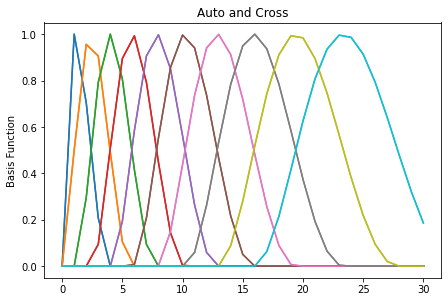

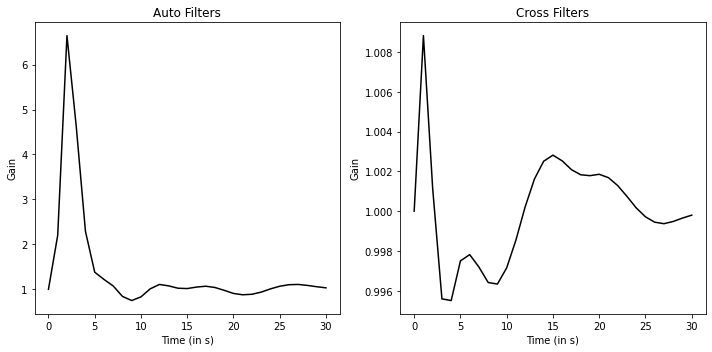

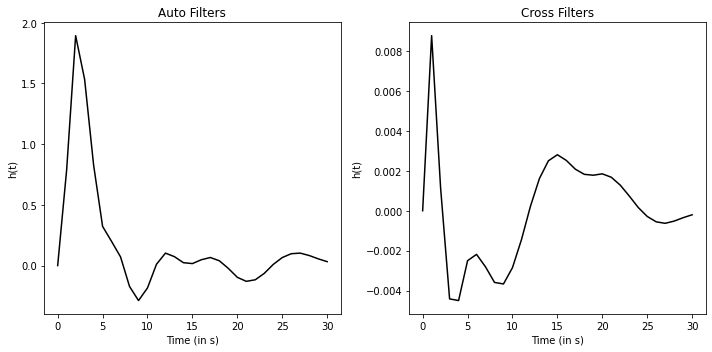

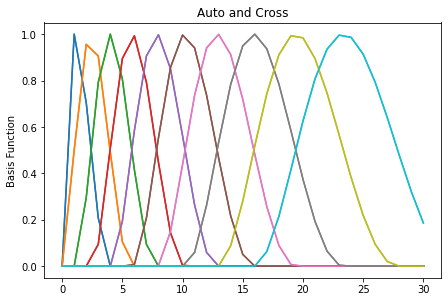

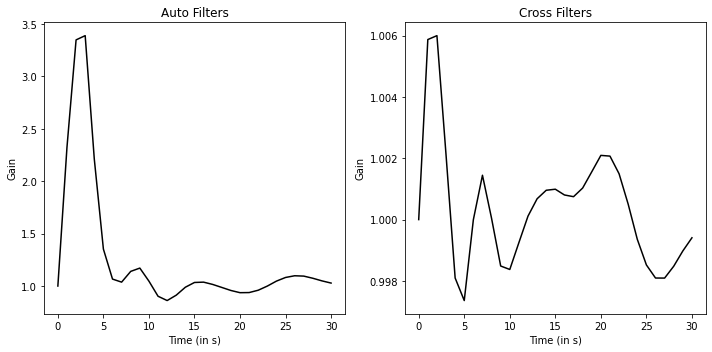

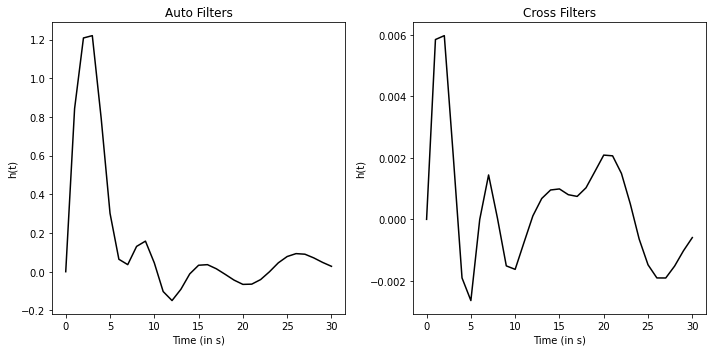

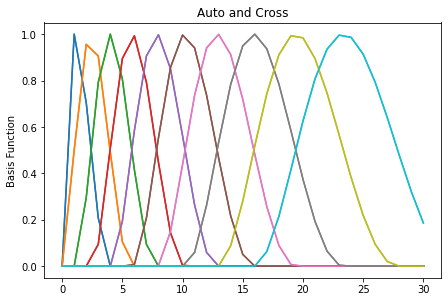

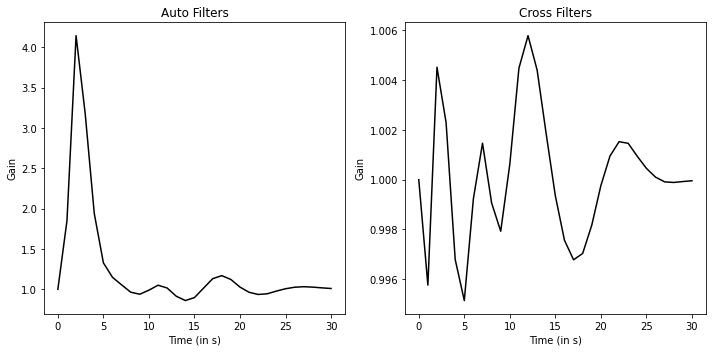

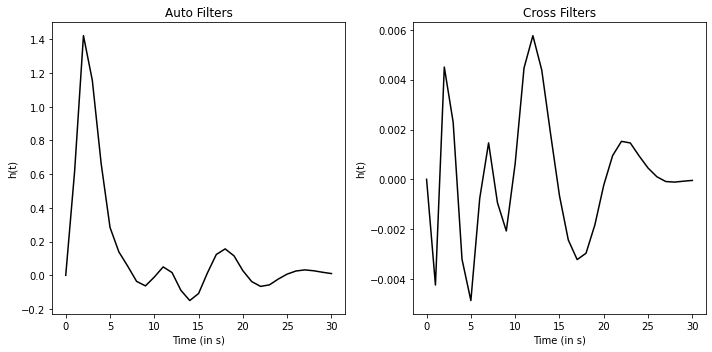

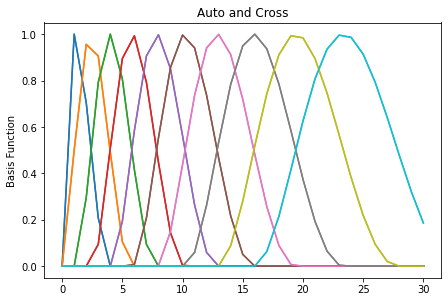

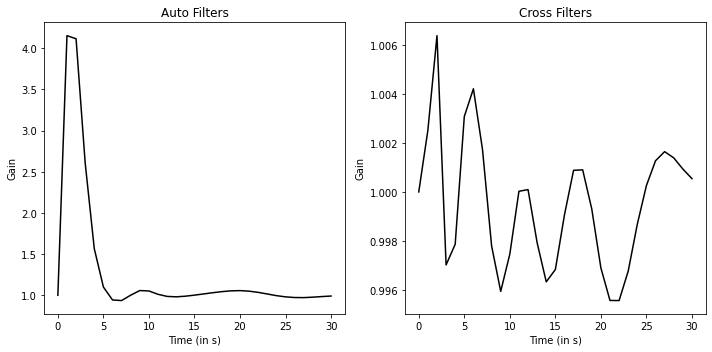

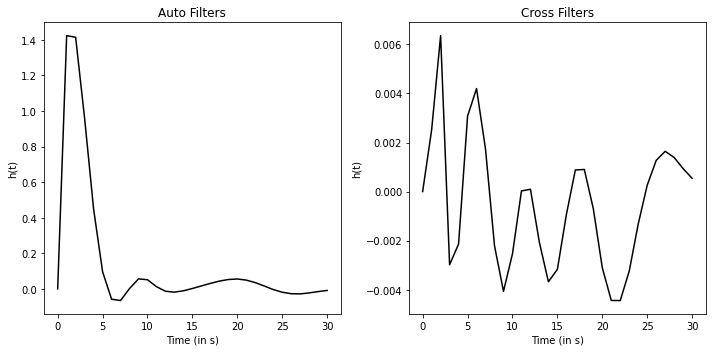

In [4]:
# Make stimulus pulses and get stimulus times, visualized below
Stim = np.zeros(10880)
dt = float(30/136)
stimtimes = []
print(dt)
for i in range(80):
    Stim[(136*i+45):(136*i+50)] = 1
    stimtimes.append(i*30+10)
Stim[np.where(Stim != 1)] = 0.4

dt = float(30/136)

# Load data
io = NWBHDF5IO('/Users/andrewaoun/Desktop/Fleischmann_Lab/data_sim/data.nosync/testing.nwb', 'r')
nwbfile_in = io.read()
flow = nwbfile_in.acquisition['flow'].data.value

# Make stimulus pulses
pulses = np.zeros(10880)
for i in range(80):
    pulses[(136*i+45):(136*i+50)] = 1

# Get relevant data out of NWB file
wheel = nwbfile_in.acquisition['wheel'].data.value
odor = nwbfile_in.stimulus['odor'].data.value

p1 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_1'].data.value
p2 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_2'].data.value
p3 = nwbfile_in.processing['ophys'].data_interfaces['Deconvolved'].roi_response_series['Plane_3'].data.value

deconvolved = np.vstack((p1,p2,p3))
spikes = np.zeros((deconvolved.shape))

for i in range(deconvolved.shape[0]):
    spikes[i, np.where(deconvolved[i, :] > (np.mean(deconvolved[i,:] + 1.96*np.std(deconvolved[i,:]))))] = 1

f1 = nwbfile_in.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['Plane_1'].data.value
f2 = nwbfile_in.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['Plane_2'].data.value
f3 = nwbfile_in.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['Plane_3'].data.value

fluorescence = np.vstack((f1,f2,f3))

# Downsample to 10880
flow = signal.resample(flow, 10880)
print('Flow', len(flow))
wheel[np.isnan(wheel)] = 0
wheel = signal.resample(wheel, 10880)
print('Wheel', len(wheel))

temp = np.zeros(10880)
for i in range(80):
    temp[i*136:(i+1)*136] = odor[i*30000]
odor = temp
print('Odor', len(odor))

# Sum spike counts for all trials of each odor in a cell (repeat for 315 cells), divide up trials by odor (Odor 1: 315 avg responses, Odor 2: 315 avg responses etc...), use for auto and cross history filters
ensembles = []
for j in range(315):
    ensemble = [[0 for i in range(136)] for i in range(10)]
    for i in range(80):
        trial = spikes[j,i*136:(i+1)*136]
        ensemble[int(odor[i])-1] += trial
    ensemble = np.sum(ensemble, axis=0)
    ensembles.append(ensemble)

m0 = {}
m1 = {}
m2 = {}
m3 = {}
m4 = {}
m5 = {}
m6 = {}
m7 = {}
m8 = {}
m9 = {}
m10 = {}

ms = [m0,m1,m2,m3,m4, m5, m6, m7, m8, m9, m10]

for i in range(len(ms)):
    ms[i]['fpr'] = []
    ms[i]['tpr'] = []
    ms[i]['AUC'] = []
    ms[i]['PP'] = []

# Build and apply all model to each cell

for i in range(315):
    # idx = np.random.randint(0, 315)
    cell = spikes[i,:]
    Y = cell.reshape(-1, 1, order='F')
    X0 =  np.ones((len(Y), 1)) 

    """ Baseline model """
    poisson_model = sm.GLM(Y, X0, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b0 = poisson_results.params.reshape(-1, 1)[0][0]
    poisson_results.params.reshape(-1, 1)
    lbda0 = np.exp(np.dot(X0, b0))/dt
    DEV0 = poisson_results.deviance

    """ Flow information """
    X1 = np.hstack((X0, flow.reshape(-1, 1, order='F'))) #### v stack, flattne X0
    # print('X1 SHAPE', X1.shape)
    poisson_model = sm.GLM(Y, X1, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b1 = poisson_results.params.reshape(-1, 1)
    lbda1 = np.exp(np.dot(X1, b1))/dt
    DEV1 = poisson_results.deviance

    """ Flow + Wheel information """
    X2 = np.hstack((X0, flow.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'))) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X2, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b2 = poisson_results.params.reshape(-1, 1)
    lbda2 = np.exp(np.dot(X2, b2))/dt
    DEV2 = poisson_results.deviance

    """ Flow + Odor information """
    X3 = np.hstack((X0, flow.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'))) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X3, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b3 = poisson_results.params.reshape(-1, 1)
    DEV3 = poisson_results.deviance
    lbda3 = np.exp(np.dot(X3, b3))/dt

    """ Flow + Odor + Wheel information """
    X4 = np.hstack((X0, flow.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'))) #### v stack, flattne X0
    # X4 = np.hstack((X0, flow.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'), Y)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X4, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b4 = poisson_results.params.reshape(-1, 1)
    DEV4 = poisson_results.deviance
    lbda4 = np.exp(np.dot(X4, b4))/dt

    """ Pulses + Odor + Wheel Information """
    X5 = np.hstack((X0, pulses.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'))) #### v stack, flattne X0
    # X4 = np.hstack((X0, flow.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'), Y)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X5, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b5 = poisson_results.params.reshape(-1, 1)
    DEV4 = poisson_results.deviance
    lbda5 = np.exp(np.dot(X5, b5))/dt


    # Code for making auto and cross history filter
    counts_all = np.sum(spikes, axis=0)
    counts_one = Y

    nBasis_auto = 10
    nBasis_cross = 10
    nTaus = 30
    ht = make_cosine_basis(nBasis_auto, 33, 10, offset=0,normalize=False)
    # print(ht.shape)
    ht = ht[:, :30]
    # print(ht.shape)
    ht = np.append(np.zeros((10, 1)), ht, axis=1) #######################
    # print(ht.shape)

    T = 30
    time = np.arange(0,T+dt,dt)
    
    nCells = 315
    N = len(time)-1

    if i <= 3:
        fig = plt.figure(figsize=(12,8))

        ax = plt.subplot(2, 2, 1)
        ax.plot(np.arange(nTaus+1), ht.T)
        ax.set_title('Auto and Cross')
        ax.set_ylabel('Basis Function')
        fig.tight_layout()

        ax = plt.subplot(2, 2, 1)
        ax.plot(np.arange(nTaus+1), ht.T)
        ax.set_title('Auto and Cross')
        ax.set_ylabel('Basis Function')
        fig.tight_layout()

    X_cross = np.ones((nBasis_cross, len(counts_one)))
    X_auto = np.zeros((nBasis_auto, len(counts_one)))
    for k in range(nBasis_auto):
        X_auto[k, :] = signal.lfilter(ht[k,:], 1, np.array(counts_one).flatten()) 
        X_cross[k, :] = signal.lfilter(ht[k,:], 1, counts_all)  

    """ Auto and Cross history filters """
    Xdsg = np.append(X_auto, X_cross, axis=0).T
    X6 = np.hstack([np.ones((Xdsg.shape[0], 1), dtype=Xdsg.dtype), Xdsg])
    # X1 = np.hstack([np.ones((N-1,1)), X_auto, X_cross])
    store = X6
    poisson_model = sm.GLM(counts_one, X6, family=Poisson(log()))
    poisson_results = poisson_model.fit()
    Bhat = poisson_results.params.reshape(-1, 1)
    lbda6 = np.exp(np.dot(X6, Bhat))/dt
    DEV = poisson_results.deviance

    """ Flow, Wheel, Odor + Auto and Cross history filters """
    X7 = np.hstack((X0, flow.reshape(-1, 1, order='F'), wheel.reshape(-1, 1, order='F'), odor.reshape(-1, 1, order='F'), Xdsg)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X7, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b7 = poisson_results.params.reshape(-1, 1)
    lbda7 = np.exp(np.dot(X7, b7))/dt
    DEV = poisson_results.deviance

    """ Cross history alone """
    Xdsg2 = X_cross.T
    X8 = np.hstack((X0, Xdsg2)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X8, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b8 = poisson_results.params.reshape(-1, 1)
    lbda8 = np.exp(np.dot(X8, b8))/dt
    DEV = poisson_results.deviance

    """ Auto history alone """
    Xdsg3 = X_auto.T
    X9 = np.hstack((X0, Xdsg3)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X9, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit()
    b9 = poisson_results.params.reshape(-1, 1)
    lbda9 = np.exp(np.dot(X9, b9))/dt
    DEV = poisson_results.deviance

    """ Odor and Auto history """
    Xdsg4 = X_auto.T
    X10 = np.hstack((X0, odor.reshape(-1, 1, order='F'), Xdsg4)) #### v stack, flattne X0
    poisson_model = sm.GLM(Y, X10, family=Poisson()) # Fit the GLM.
    poisson_results = poisson_model.fit(method="lbfgs")
    b10 = poisson_results.params.reshape(-1, 1)
    lbda10 = np.exp(np.dot(X10, b10))/dt
    DEV = poisson_results.deviance

    # Collect fpr, tpr, auc and PP rates for all runs
    if i <= 3:
        # print(Bhat.shape)
        auto = Bhat[1:nBasis_auto+1]
        cross = Bhat[nBasis_auto+1:].reshape(1,10)
        # auto = Bhat[:nBasis_auto]
        # cross = Bhat[nBasis_auto:].reshape(2,4)
        temp_t = np.arange(nTaus+1)


        fig = plt.figure(figsize=(10,5))
        ax = plt.subplot(1,2,1)
        ax.plot(temp_t, np.exp(np.dot(ht.T, auto)), 'k')
        ax.set_xlabel('Time (in s)')
        ax.set_ylabel('Gain')
        ax.set_title('Auto Filters')
        # ax.set_xlim(0,50)
        # ax.set_ylim(-1,2)

        to_store = cross
        ax = plt.subplot(1,2,2)
        ax.plot(temp_t, np.exp(np.dot(ht.T,  np.transpose(cross))), 'k')
        ax.set_xlabel('Time (in s)')
        ax.set_ylabel('Gain')
        ax.set_title('Cross Filters')
        # ax.set_xlim(5,40)
        # ax.set_ylim(0,0.02)
        fig.tight_layout()

        fig = plt.figure(figsize=(10,5))
        ax = plt.subplot(1,2,1)
        ax.plot(temp_t, np.dot(ht.T, auto), 'k')
        ax.set_xlabel('Time (in s)')
        ax.set_ylabel('h(t)')
        ax.set_title('Auto Filters')
        # ax.set_xlim(0,50)
        # ax.set_ylim(-1,2)

        ax = plt.subplot(1,2,2)
        ax.plot(temp_t, np.dot(ht.T, np.transpose(cross)), 'k')
        ax.set_xlabel('Time (in s)')
        ax.set_ylabel('h(t)')
        ax.set_title('Cross Filters')
        # ax.set_xlim(5,40)
        # ax.set_ylim(-1,2)
        fig.tight_layout()



    # DEV1 better than DEV0
    dof = 2-1
    D = float(DEV0 - DEV1)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV1 better than DEV0', pval)

    # DEV2 better than DEV0
    dof = 3-1
    D = float(DEV0 - DEV2)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV2 better than DEV0', pval)

    # DEV3 better than DEV0
    dof = 4-1
    D = float(DEV0 - DEV3)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV3 better than DEV0', pval)

    # DEV4 better than DEV0
    dof = 5-1
    D = float(DEV0 - DEV4)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV4 better than DEV0', pval)

    # DEV1 no better than DEV2 and vice versa
    dof = 3-2
    D = float(DEV1 - DEV2)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV1 no better than DEV2 and vice versa', pval)

    # DEV3 better than DEV1
    dof = 4-2
    D = float(DEV1 - DEV3)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV3 better than DEV1', pval)

    # DEV3 better than DEV2
    dof = 4-3
    D = float(DEV2 - DEV3)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV3 better than DEV2', pval)

    # DEV4 better than DEV1
    dof = 5-2
    D = float(DEV1 - DEV4)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV4 better than DEV1', pval)

    # DEV4 better than DEV2
    dof = 5-3
    D = float(DEV2 - DEV4)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV4 better than DEV2', pval)

    # DEV4 better than DEV3
    dof = 5-4
    D = float(DEV3 - DEV4)
    pval = float(1 - chi2.cdf(D,dof))
    # print('DEV4 better than DEV3', pval)

    from sklearn.metrics import roc_curve, auc, precision_recall_curve

    lbdas = [lbda0,lbda1,lbda2,lbda3,lbda4, lbda5, lbda6, lbda7, lbda8, lbda9, lbda10]

    # fig = plt.figure(figsize=(10,10))

    c = 0
    for i in range(len(lbdas)):
        fpr, tpr, _ = roc_curve(Y, lbdas[i])

        AUC = auc(fpr, tpr)

        PP = 2 * (AUC - 0.5)

        fpr = list(fpr)
        tpr = list(tpr)
        ms[i]['fpr'].append(fpr)
        ms[i]['tpr'].append(tpr)
        ms[i]['AUC'].append(AUC)
        ms[i]['PP'].append(PP)

        # print('AUC: ' + str(AUC))
        # print('PP: ' + str(PP))

        # plt.plot(fpr, tpr, lw=1, label='Model ' + str(c) + ' CIF with AUC = ' + str(round(AUC,3)) + '; PP = ' + str(round(PP,3)))
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # c += 1

    # plt.legend()
    # plt.show()

In [5]:
np.array(ensembles).shape

(315, 136)

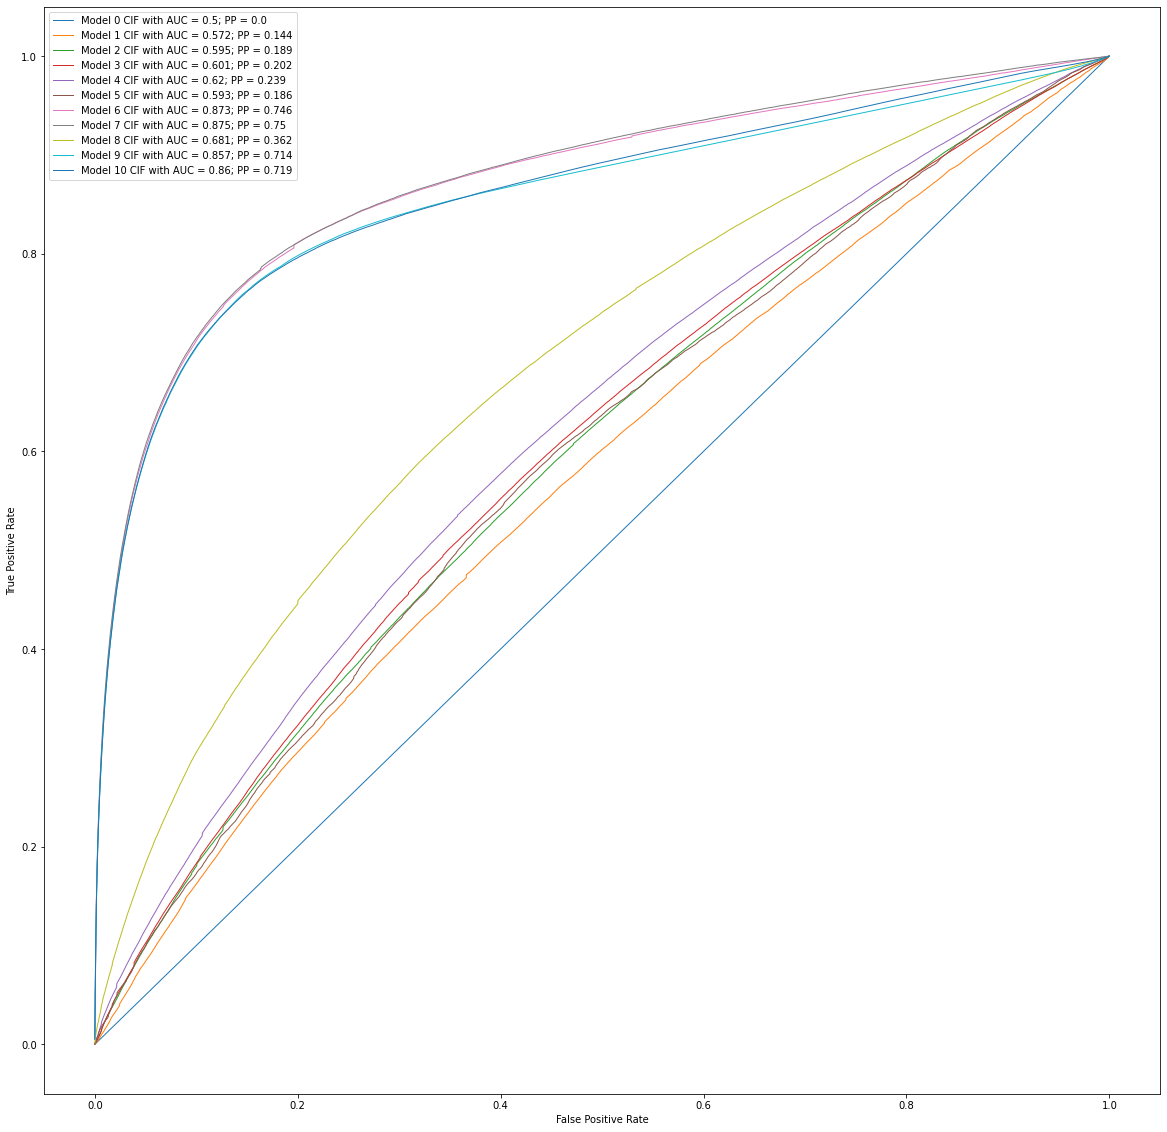

In [6]:
fig = plt.figure(figsize=(20,20))

for i in range(len(ms)):

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate(ms[i]['fpr']))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for j in range(315):
        mean_tpr += interp(all_fpr, ms[i]['fpr'][j], ms[i]['tpr'][j])

    # Finally average it and compute AUC
    mean_tpr /= 315

    fpr = all_fpr
    tpr = mean_tpr

    # fpr = []
    # for j in range(315):
    #     fpr.append(np.mean(ms[i]['fpr'][j]))

    # tpr = []
    # for j in range(315):
    #     tpr.append(np.mean(ms[i]['tpr'][j]))

    # fpr = np.mean(np.reshape(np.array(ms[i]['fpr']), (315,2)), axis=0)
    # tpr = np.mean(np.reshape(np.array(ms[i]['tpr']), (315,2)), axis=0)
    AUC = np.mean(np.array(ms[i]['AUC']))
    PP = np.mean(np.array(ms[i]['PP']))

    plt.plot(fpr, tpr, lw=1, label='Model ' + str(i) + ' CIF with AUC = ' + str(round(AUC,3)) + '; PP = ' + str(round(PP,3)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

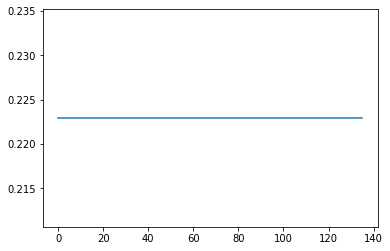

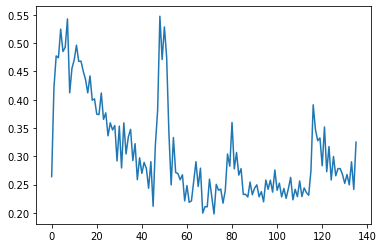

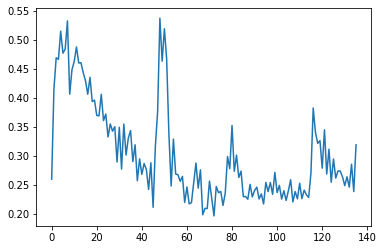

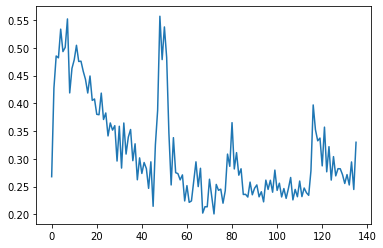

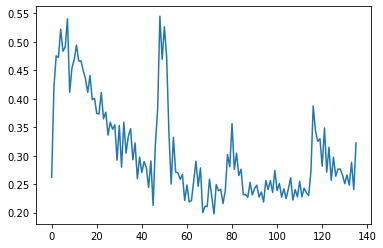

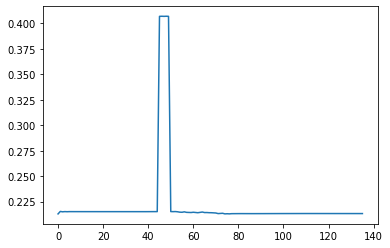

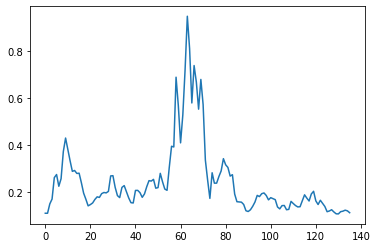

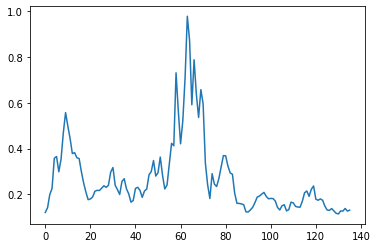

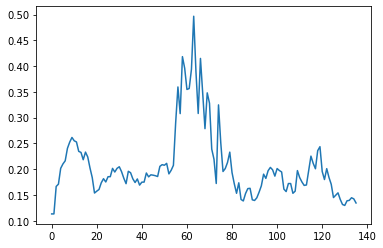

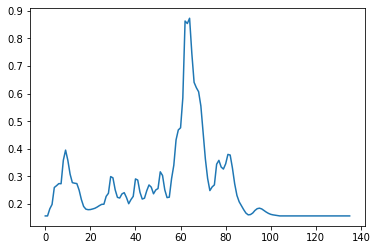

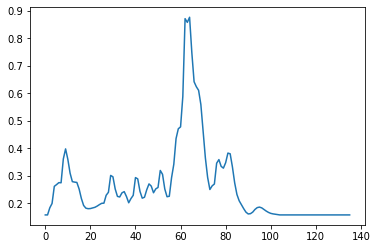

In [7]:
# Predicted intensity function by each model, the first model with a straight line represents a sort of 'baseline' firing rate
for lbda in lbdas:
    plt.plot(lbda[0:136])
    plt.show()

In [8]:
""" THIS SECTION BELOW CAN BE USED TO CHECK P VALUE OF MODEL COMPARISONS

p-value close to 0 or = to 0 means, for model X - model Y, model Y is a significantly better model

adjust dof as number of parameters in model

"""

# # DEV1 better than DEV0
# dof = 2-1
# D = float(DEV0 - DEV1)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV1 better than DEV0', pval)

# # DEV2 better than DEV0
# dof = 3-1
# D = float(DEV0 - DEV2)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV2 better than DEV0', pval)

# # DEV3 better than DEV0
# dof = 4-1
# D = float(DEV0 - DEV3)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV3 better than DEV0', pval)

# # DEV4 better than DEV0
# dof = 5-1
# D = float(DEV0 - DEV4)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV4 better than DEV0', pval)

# # DEV1 no better than DEV2 and vice versa
# dof = 3-2
# D = float(DEV1 - DEV2)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV1 no better than DEV2 and vice versa', pval)

# # DEV3 better than DEV1
# dof = 4-2
# D = float(DEV1 - DEV3)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV3 better than DEV1', pval)

# # DEV3 better than DEV2
# dof = 4-3
# D = float(DEV2 - DEV3)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV3 better than DEV2', pval)

# # DEV4 better than DEV1
# dof = 5-2
# D = float(DEV1 - DEV4)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV4 better than DEV1', pval)

# # DEV4 better than DEV2
# dof = 5-3
# D = float(DEV2 - DEV4)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV4 better than DEV2', pval)

# # DEV4 better than DEV3
# dof = 5-4
# D = float(DEV3 - DEV4)
# pval = float(1 - chi2.cdf(D,dof))
# print('DEV4 better than DEV3', pval)



DEV1 better than DEV0 3.5981585168043395e-06
DEV2 better than DEV0 2.217571607898705e-06
DEV3 better than DEV0 7.292947418902074e-05
DEV4 better than DEV0 0.0025732419047783672
DEV1 no better than DEV2 and vice versa 0.03252950093362894
DEV3 better than DEV1 0.8610171510532811
DEV3 better than DEV2 1.0
DEV4 better than DEV1 1.0
DEV4 better than DEV2 1.0
DEV4 better than DEV3 1.0
